In [14]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import json

In [15]:
with open( '../Data/VAF_Data/p377_variant_summary.html', 'r') as mf:
    file = mf.read()

In [16]:
soup = BeautifulSoup(file, 'html.parser')

mysoup = soup.body.div.find_all("script")

mysoup = soup.body.div.find_all("script")[1].contents[0].strip()

In [17]:
table_dict = json.loads(mysoup)

columns = [stuff["label"][0] for stuff in table_dict["columns"]]

table_dict["data"]

data = []
for stuff in table_dict["data"]:
    rows = []
    for key in stuff:
        rows.append(stuff[key])
    data.append(rows)
    
variant_annotations = pd.DataFrame(data, columns = columns)

In [18]:
#Convert patient IDs
variant_annotations['pat'] = variant_annotations['PATIENT']

init_dict = {
    'IID_H198302': 'PD7153',
    'IID_H198303': 'PD7151',
    'IID_H198304': 'JP001'
}

variant_annotations['patient_init'] = variant_annotations['pat'].replace(init_dict)

In [19]:
#Add in cell type
variant_annotations['cel'] = variant_annotations['TARGET_NAME']
ct_dict = {
    'T01': 'BM',
    'T02': 'Mono',
    'T03': 'nBC',
    'T04': 'Neut'
}

patients = variant_annotations['TARGET_NAME'].to_list()
cells = []
for pat in patients: 
    for a in ct_dict:
        x = (pat.split('_')[2])
        if a == x:
            cells.append(ct_dict[a])
            
cell_dict = dict(zip(patients, cells))   

variant_annotations['celltype'] = variant_annotations['cel'].replace(cell_dict)

variant_annotations = variant_annotations.drop(columns = ['cel', 'pat'])

In [20]:
#Add in PCR amplicon name
variant_annotations['Mean_VAF'] = pd.to_numeric(variant_annotations['TARGET_VAF_MEAN'], downcast = 'float')

In [21]:
#Convert protein changes to amplicon names
meta = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx')
mut = meta['MUT_NAME'].to_list()
prot = meta['PROTEIN_CHANGE'].to_list()
amp_assign = dict(zip(prot, mut))
old = 'p.Q1276* aka p.Q1265*'
new = 'p.Q1276*'
amp_assign[new] = amp_assign.pop(old)
print(len(amp_assign), amp_assign)

variant_annotations['Amplicon'] = variant_annotations['PROTEIN_CHANGE'].replace(amp_assign)

11 {'p.P95H': 'PD7153_SRSF2', 'p.L1065fs*1': 'PD7153_TET2a', 'p.Q685*': 'PD7153_TET2b', 'p.T360M': 'PD7153_TGFB3_g', 'p.K1090fs*15': 'PD7151_TET2a', 'p.A1224fs*2': 'PD7151_TET2b', 'p.A187T': 'JP001_RUNX1_g', 'p.P95R': 'JP001_SRSF2', 'p.G1218fs*8': 'JP001_TET2a', 'p.Y1337*': 'JP001_TET2b_g', 'p.Q1276*': 'PD7153_CUX1'}


In [22]:
# Make a smaller df that just contains PCR amplicons in it
variant_annotations_amps = variant_annotations.loc[variant_annotations['Amplicon'].isin(mut)]

#Test for where amplicon assignment doesn't fit patient (ie/ PD7151 SRSF2 which gets incorrectly labelled as a different patient because it wasn't PCR amplified)
pt_test = []
for index, row in variant_annotations_amps.iterrows():
    pt_test.append(row['Amplicon'].split('_')[0])

variant_annotations_amps['pt_test'] = pt_test

variant_annotations_amps = variant_annotations_amps.loc[variant_annotations_amps['pt_test'] == variant_annotations_amps['patient_init']]   

<ipython-input-22-3f06ba998420>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variant_annotations_amps['pt_test'] = pt_test


In [23]:
#Create empty values for PD7151 missing amplicon
cs = list(variant_annotations_amps.columns)
blank1 = ['TARGET_NAME',
 'PATIENT',
 'CHR',
 'START',
 'END',
 'REF',
 'ALT',
 'GENE',
 'PROTEIN_CHANGE',
 'cDNA_CHANGE',
 'TARGET_VAF_MEAN',
 'Autotate_annot1',
 'Autotate_annot2',
 'VARIANT',
 'sampleID_short',
 'PD7151',
 'Neut',
 '-0.1',
 'PD7151_TET2a',
 'PD7151']
blank2 = ['TARGET_NAME',
 'PATIENT',
 'CHR',
 'START',
 'END',
 'REF',
 'ALT',
 'GENE',
 'PROTEIN_CHANGE',
 'cDNA_CHANGE',
 'TARGET_VAF_MEAN',
 'Autotate_annot1',
 'Autotate_annot2',
 'VARIANT',
 'sampleID_short',
 'PD7151',
 'Neut',
 '-0.21',
 'PD7151_TET2b',
 'PD7151']
blank = pd.DataFrame(np.array([blank1, blank2]),columns=cs)

In [24]:
#Create a new df with the blank values and rearrange for plotting
var_ann_blank = pd.concat([variant_annotations_amps, blank])
var_ann_blank = var_ann_blank[['celltype', 'Mean_VAF', 'Amplicon', 'patient_init']]
var_ann_blank.sort_values(by=['Amplicon'], inplace = True)
var_ann_blank.sort_values(by=['celltype'], inplace = True)

In [25]:
#Rearrange again
patients = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
short_label = ['SRSF2',
        'TET2[b]',
        'TET2[a]',
        'TET2[a]', 
        'TET2[b]',
        'TET2[b]', 
        'SRSF2', 
        'RUNX1',
        'CUX1',
        'TET2[a]'
       ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

cell_order = ['BM', 'Mono', 'Neut', 'nBC']
cell_order_map = {x:i for i, x in enumerate(cell_order)}

var_ann_blank['x_value'] = var_ann_blank['celltype'].map(cell_order_map)

var_ann_blank.loc[var_ann_blank['Amplicon'] == 'JP001_SRSF2', 'x_value'] -= 0.12
var_ann_blank.loc[var_ann_blank['Amplicon'] == 'JP001_TET2a', 'x_value'] -= 0.04
var_ann_blank.loc[var_ann_blank['Amplicon'] == 'JP001_TET2b_g', 'x_value'] += 0.04
var_ann_blank.loc[var_ann_blank['Amplicon'] == 'JP001_RUNX1_g', 'x_value'] += 0.12

var_ann_blank.loc[var_ann_blank['Amplicon'] == 'PD7153_TET2b', 'x_value'] -= 0.08
#var_ann_blank.loc[var_ann_blank['Amplicon'] == 'PD7153_TET2a', 'x_value'] -= 0.0
var_ann_blank.loc[var_ann_blank['Amplicon'] == 'PD7153_SRSF2', 'x_value'] += 0.08

var_ann_blank.loc[var_ann_blank['Amplicon'] == 'PD7151_TET2b', 'x_value'] -= 0.04
var_ann_blank.loc[var_ann_blank['Amplicon'] == 'PD7151_TET2a', 'x_value'] += 0.04

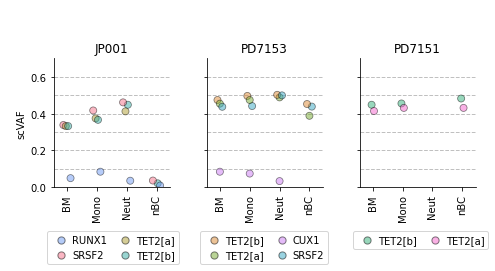

In [27]:
#Plot the VAFS
fig, (ax1,ax) = plt.subplots(2, 3, figsize = (7,4), gridspec_kw = dict(height_ratios = [1,4]), sharex = True)

#Adding dummy plot at top to match spacing exactly with scVAF plot
for count, patient in enumerate(patients):
    ax1[count].set_yscale('log')
    ax1[count].set_ylim(1, 1000)
    ax1[count].set_yticks([1, 10, 100, 1000])
    ax1labels = ['', 10, 100, 1000]
    ax1[count].set_yticklabels(ax1labels, color = 'white') 
    #ax1[count].set_title(f'{patient}') 
    ax1[count].spines['top'].set_visible(False)
    ax1[count].spines['right'].set_visible(False)
    ax1[count].spines['bottom'].set_visible(False)
    ax1[count].spines['left'].set_visible(False)
    ax1[count].tick_params(axis='x', colors='white')
    ax1[count].tick_params(axis='y', colors='white')    
    if count != 0:
        ax1[count].set_yticklabels([])
    else:
        ax1[count].set_ylabel('Cell #', color = 'white')

for count, patient in enumerate(patients):
    plot_data = var_ann_blank.loc[var_ann_blank['patient_init'].isin([patient])]
    
                
    sns.scatterplot(x = 'x_value', y = 'Mean_VAF', data = plot_data,  s = 50, hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, edgecolor = 'black', ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels()
    lbl = []
    for lb in labels[1:]:
        lbl.append(relabel[lb])    
    
    lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [-0.1,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 2, markerscale = 1.2, handles=handles[1:], labels=lbl)
    #ax[count].set_title(f'{patient}') 
    ax[count].set_ylim(0,0.7)
    ax[count].axhline(0.1, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].margins(x=0.1)
    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    ax[count].set_title(f'{patient}')

    ax[count].spines['top'].set_visible(False)
    ax[count].spines['right'].set_visible(False)
    
    if count != 0:
        ax[count].set_yticklabels([])
    else:
        ax[count].set_ylabel('bulkVAF')
    
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
        lh.set_edgecolor('black')

plt.rcParams['svg.fonttype'] = 'none'  
fig.tight_layout(h_pad = 0, w_pad = 2)     
fig.savefig('../Results/Bulk_VAFs.svg',bbox_inches='tight', dpi = 600)